In [1]:
import os

In [2]:
root_path = '../input/heatmap-of-salicon-dataset/coco'
os.listdir(root_path)

['heatmaps', 'images', '._images']

In [3]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
import torch
from torch import nn, optim
import numpy as np
import random

In [4]:
class SaliencyDataset(Dataset):
    def __init__(self,mode='train',img_transformations = None):
        
        self.heatmap_path_list = glob.glob(f"{root_path}/heatmaps/COCO_{mode}*.jpg")
        self.img_transformations = img_transformations
    
    def __getitem__(self,index):
        heatmap_path = self.heatmap_path_list[index]
        image_path = f"{root_path}/images/"+heatmap_path.split('/')[-1]
        
        heatmap = Image.open(heatmap_path)
        image = Image.open(image_path).convert('RGB')
        
        if self.img_transformations is not None:
            image = self.img_transformations(image)
        
        to_tensor = transforms.ToTensor()
        resize_img = transforms.Resize(240)
        resize_hmp = transforms.Resize(30)
        
        return to_tensor(resize_hmp(heatmap)) , to_tensor(resize_img(image))
    
    def __len__(self):
        return len(self.heatmap_path_list)
    

In [5]:
batch_size = 8

image_transformations = transforms.Compose([
    transforms.ColorJitter(0.1,0.1,0.1,0.1)
])

dataset = SaliencyDataset(img_transformations=image_transformations)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=2)

dataset_val = SaliencyDataset('val')
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=2)

torch.Size([8, 1, 30, 40]) torch.Size([8, 3, 240, 320])


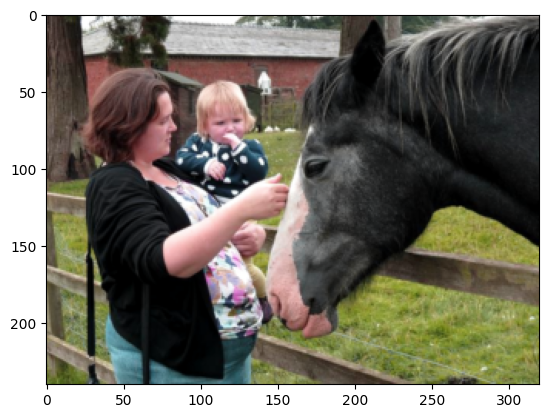

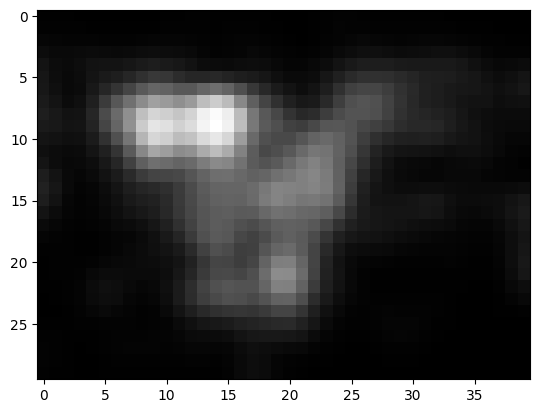

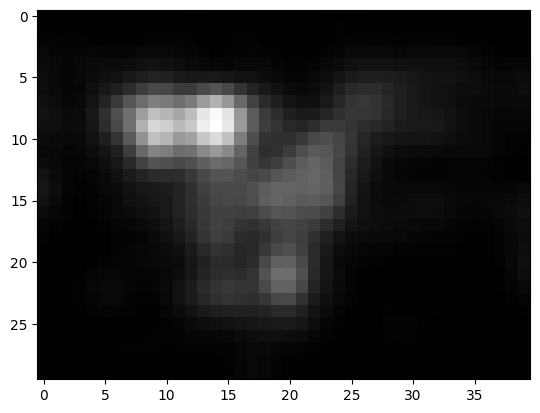

In [6]:
heatmaps, images = next(iter(loader))

print(heatmaps.shape, images.shape)

plt.imshow(images[0].permute(1,2,0))
plt.show()

heatmap = heatmaps[0].view(30,40)
plt.imshow(heatmap, cmap='Greys_r')
plt.show()

heatmap = torch.softmax(heatmaps[0].view(-1), dim=0).view(30,40)
plt.imshow(heatmap, cmap="Greys_r")
plt.show()

In [7]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        
        self.resblock = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels, affine=True)
        )
        
    def forward(self, x):
        out = self.resblock(x)
        return out + x

In [8]:
class Upsample2d(nn.Module):
    def __init__(self, scale_factor):
        super(Upsample2d, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode='nearest')
        return x

In [9]:
class MicroResNet(nn.Module):
    def __init__(self):
        super(MicroResNet, self).__init__()
        
        self.downsampler = nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(3,8,kernel_size=9, stride=4),
            nn.InstanceNorm2d(8, affine=True),
            nn.ReLU(),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8,16, kernel_size=3, stride=2),
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU(),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(16,32, kernel_size=3, stride=2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
        )
        
        self.residual = nn.Sequential(
            ResBlock(32),
            nn.Conv2d(32,64, kernel_size=1, bias=False, groups=32),
            ResBlock(64)
        )
        
        self.segmentator = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,16,kernel_size=3),
            nn.InstanceNorm2d(16,affine=True),
            nn.ReLU(),
            
            Upsample2d(scale_factor=2),
            nn.ReflectionPad2d(4),
            nn.Conv2d(16,1,kernel_size=9),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        out = self.downsampler(x)
        out = self.residual(out)
        out = self.segmentator(out)
        return out

In [10]:
model = MicroResNet()

In [11]:
heatmaps, images = next(iter(loader))
pred = model(images)
print(pred.shape, heatmaps.shape)

torch.Size([8, 1, 30, 40]) torch.Size([8, 1, 30, 40])


In [12]:
epochs = 20
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
model.cuda()
for e in range(1, epochs+1):
    total_loss = 0
    total_acc = 0
    valid_loss = 0
    valid_acc = 0
    batch = 0
    model.train()
    scheduler.step()
    for heatmaps, images in loader:
        heatmaps, images = heatmaps.cuda(), images.cuda()
        batch += 1
        optimizer.zero_grad()
        batch_size = images.size(0)

        pred = model.forward(images)
        
        pred_softmax = torch.softmax(pred.view(batch_size, -1), dim=1)
        heatmaps_softmax = torch.softmax(heatmaps.view(batch_size, -1), dim=1)
        loss = criterion(pred_softmax, heatmaps_softmax) * 1e6
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # accuracy 
        pred_binary = torch.zeros_like(pred)
        pred_binary[ pred > (pred.max()*0.25) ] = 1
        
        heatmaps_binary = torch.zeros_like(heatmaps)
        heatmaps_binary[ heatmaps > (heatmaps.max()*0.25) ] = 1
        
        equals = pred_binary == heatmaps_binary
        accuracy = torch.mean(equals.type(torch.FloatTensor))
        total_acc += accuracy
        
        if batch % 125 == 0:
            print(f"EPOCH {e} ({batch}/{len(loader)}) - loss {total_loss/batch:.4f} - acc {total_acc/batch:.4f}")
          
    model.eval()
    with torch.no_grad():
        for heatmaps, images in loader_val: 
            heatmaps, images = heatmaps.cuda(), images.cuda()
            batch_size = images.size(0)
            
            pred = model.forward(images)
            
            pred_softmax = torch.softmax(pred.view(batch_size, -1), dim=1)
            heatmaps_softmax = torch.softmax(heatmaps.view(batch_size, -1), dim=1)
            loss = criterion(pred_softmax, heatmaps_softmax) * 1e6
            valid_loss += loss
            
            # accuracy
            pred_binary = torch.zeros_like(pred)
            pred_binary[ pred > (pred.max()*0.25) ] = 1

            heatmaps_binary = torch.zeros_like(heatmaps)
            heatmaps_binary[ heatmaps > (heatmaps.max()*0.25) ] = 1

            equals = pred_binary == heatmaps_binary
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            valid_acc += accuracy
   
    print(f"EPOCH {e} ({len(loader)}/{len(loader)}) - loss {total_loss/len(loader):.4f} - acc {total_acc/len(loader):.4f} - val_loss: {valid_loss/len(loader_val):.4f} - valid_acc: {valid_acc/len(loader_val):.4f}")

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


EPOCH 1 (125/1250) - loss 0.0187 - acc 0.1634
EPOCH 1 (250/1250) - loss 0.0173 - acc 0.1620
EPOCH 1 (375/1250) - loss 0.0166 - acc 0.1638
EPOCH 1 (500/1250) - loss 0.0162 - acc 0.1653
EPOCH 1 (625/1250) - loss 0.0157 - acc 0.1660
EPOCH 1 (750/1250) - loss 0.0154 - acc 0.1660
EPOCH 1 (1250/1250) - loss 0.0145 - acc 0.1684
EPOCH 1 (1250/1250) - loss 0.0145 - acc 0.1684 - val_loss: 0.0128 - valid_acc: 0.1933
EPOCH 2 (125/1250) - loss 0.0127 - acc 0.1792
EPOCH 2 (250/1250) - loss 0.0126 - acc 0.1884
EPOCH 2 (375/1250) - loss 0.0125 - acc 0.2013
EPOCH 2 (500/1250) - loss 0.0124 - acc 0.2266
EPOCH 2 (625/1250) - loss 0.0124 - acc 0.2566
EPOCH 2 (750/1250) - loss 0.0124 - acc 0.2901
EPOCH 2 (875/1250) - loss 0.0123 - acc 0.3241
EPOCH 2 (1000/1250) - loss 0.0122 - acc 0.3622
EPOCH 2 (1125/1250) - loss 0.0122 - acc 0.4004
EPOCH 2 (1250/1250) - loss 0.0122 - acc 0.4350
EPOCH 2 (1250/1250) - loss 0.0122 - acc 0.4350 - val_loss: 0.0115 - valid_acc: 0.7828
EPOCH 3 (125/1250) - loss 0.0117 - acc 0.7

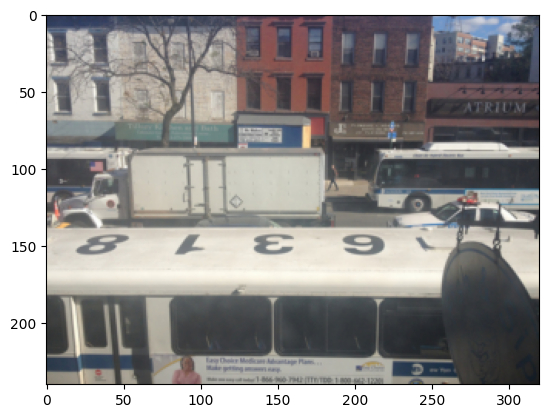

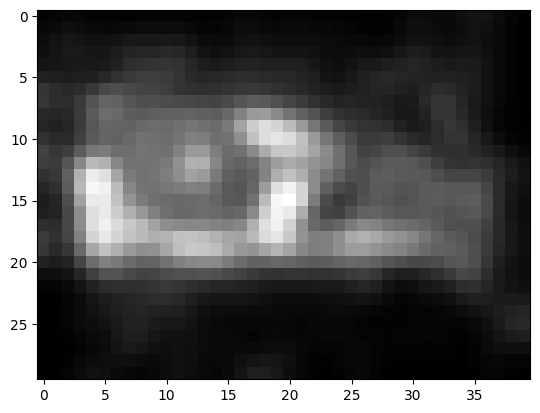

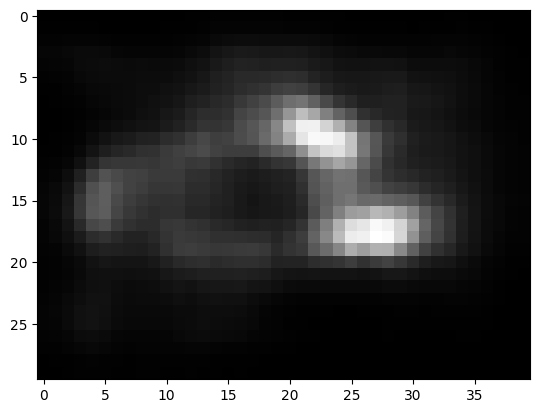

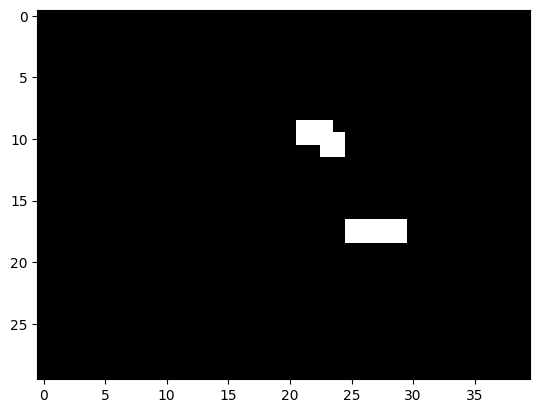

CENTER tensor(19.7940) tensor(14.0790)


In [14]:
with torch.no_grad():
    model.eval()
    model.cuda()
    heatmaps, images = next(iter(loader_val))

    preds = model(images.cuda()).cpu()

    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()

    heatmap = torch.softmax(heatmaps[0].view(-1), dim=0).view(30, 40)
    plt.imshow(heatmap, cmap='Greys_r')
    plt.show()

    temperature = 0.25
    tempered_pred = torch.log(torch.softmax(preds[0].view(-1), dim=0)) / temperature
    tempered_pred = torch.exp(tempered_pred) / torch.sum(torch.exp(tempered_pred))
    
    pred = tempered_pred.view(30, 40)
    plt.imshow(pred, cmap='Greys_r')
    plt.show()
    
    pred_bin = torch.zeros_like(pred)
    pred_bin[pred >= pred.max()*0.75] = 1
    plt.imshow(pred_bin, cmap='Greys_r')
    plt.show()
    
    center_x, center_y = 0, 0
    for i in range(pred.size(0)):
        for j in range(pred.size(1)):
            center_x += j * pred[i, j]
            center_y += i * pred[i, j]
    
    print("CENTER", center_x, center_y)

In [15]:
model.cpu()
torch.save(model.state_dict(), '/kaggle/working/saliency_model_v11.pt')

In [16]:
class TestDataset(Dataset):
    def __init__(self):
        self.image_path_list = glob.glob(f"../input/heatmap-of-salicon-dataset/coco/images/*.jpg")
        
    def __getitem__(self, index):
        image_path = self.image_path_list[index]
                
        image = Image.open(image_path).convert('RGB')
        
        to_tensot = transforms.ToTensor()
        resize_img = transforms.Resize(240)
        
        return to_tensot(resize_img(image))

    def __len__(self):
        return len(self.image_path_list)
      
dataset_test = TestDataset()
loader_test = DataLoader(dataset_test, batch_size=1)

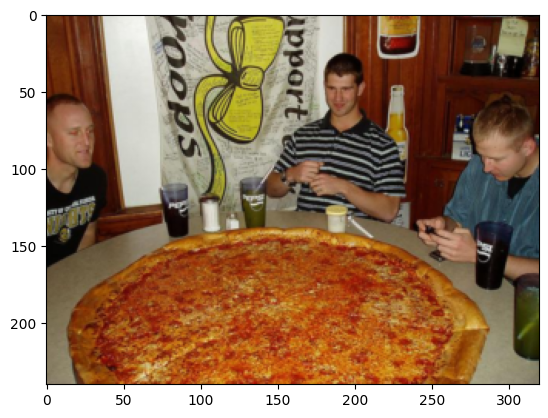

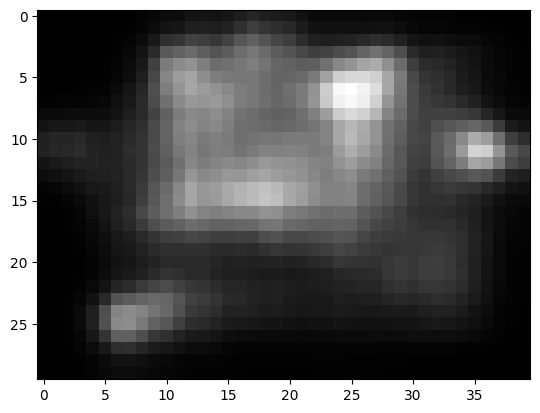

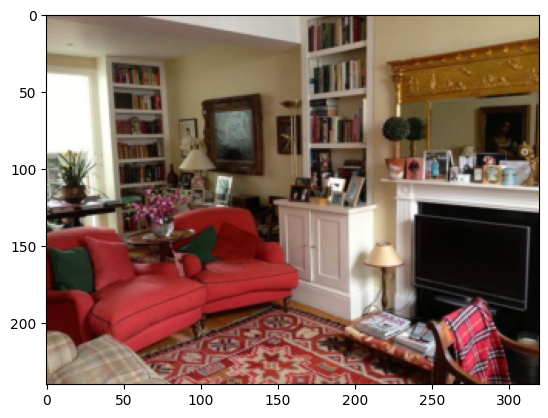

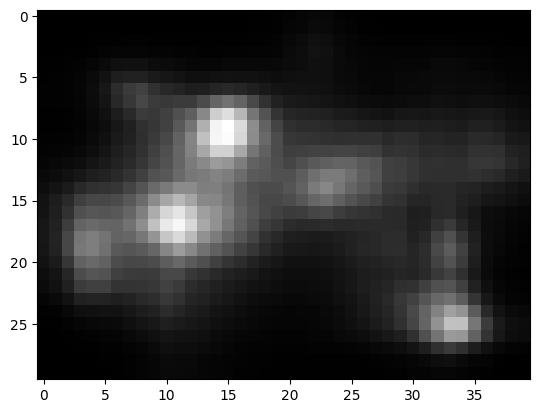

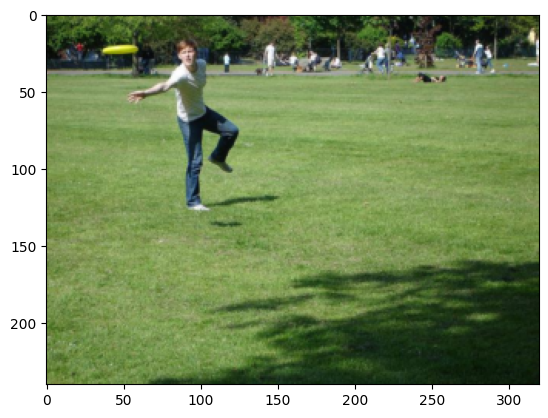

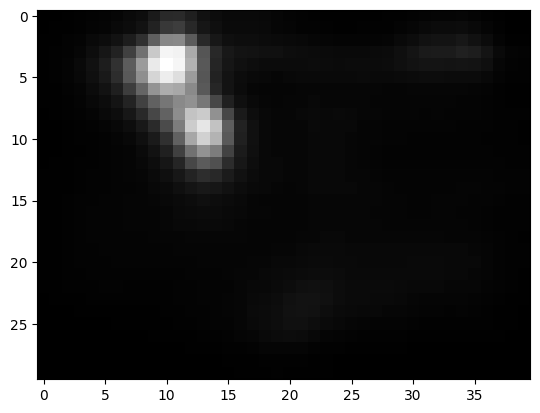

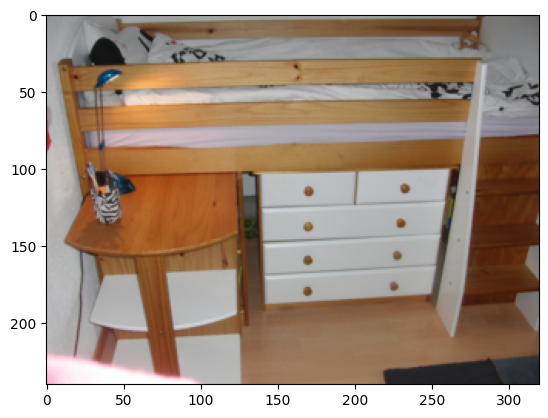

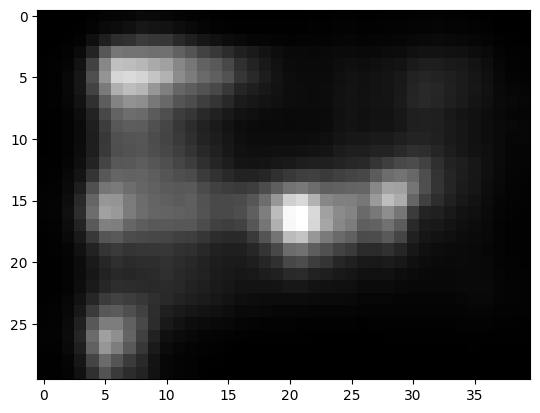

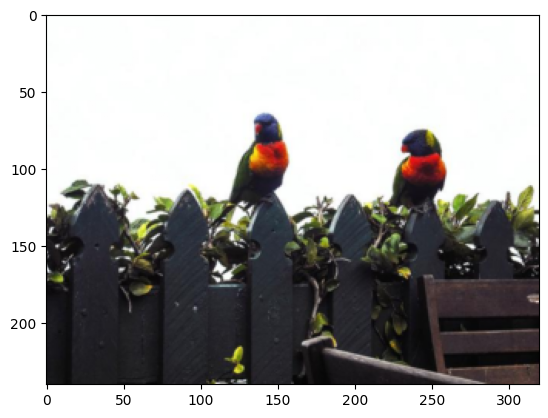

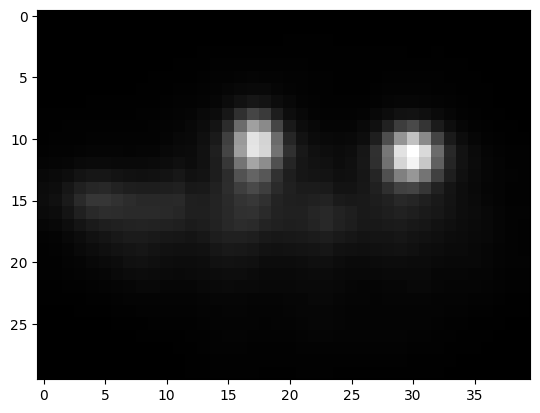

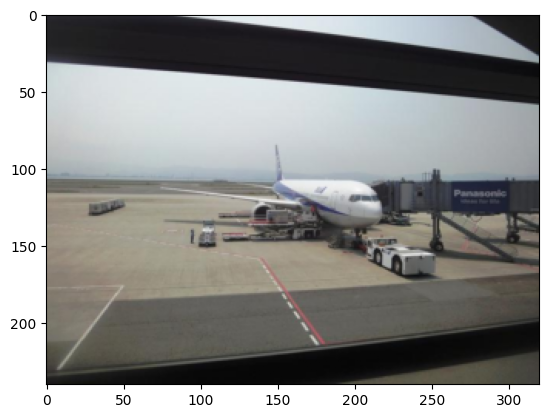

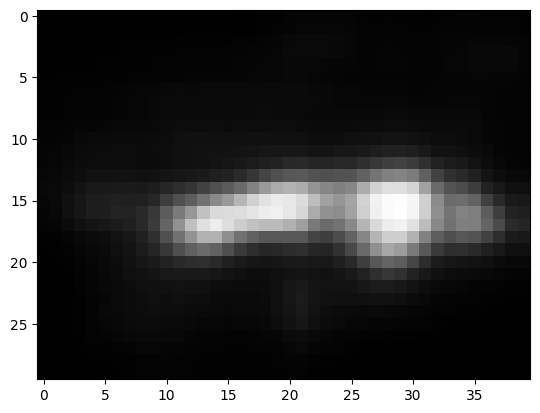

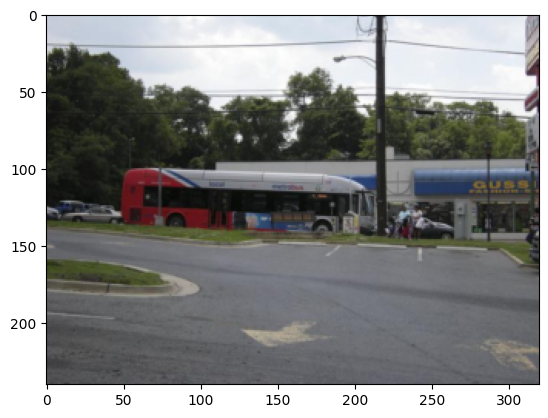

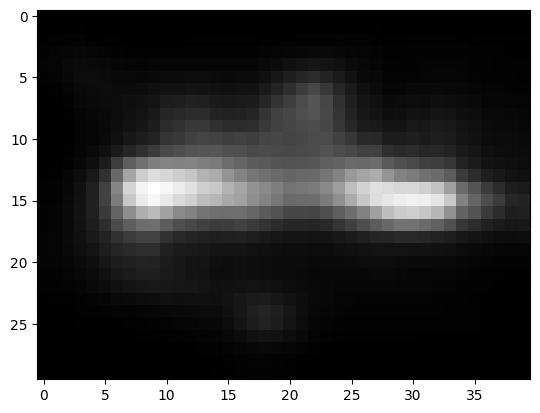

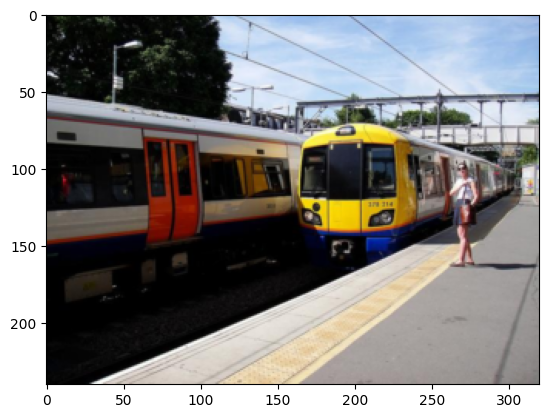

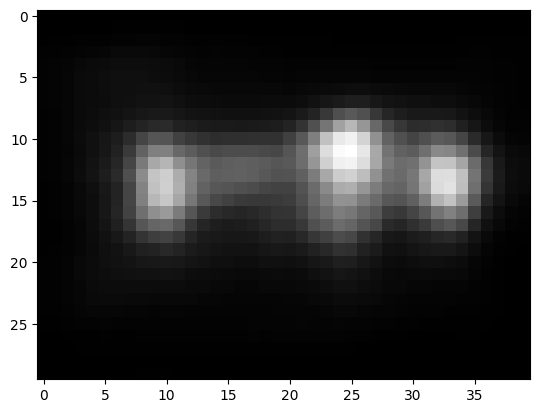

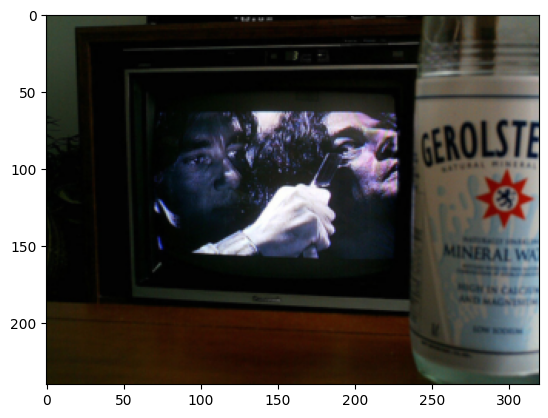

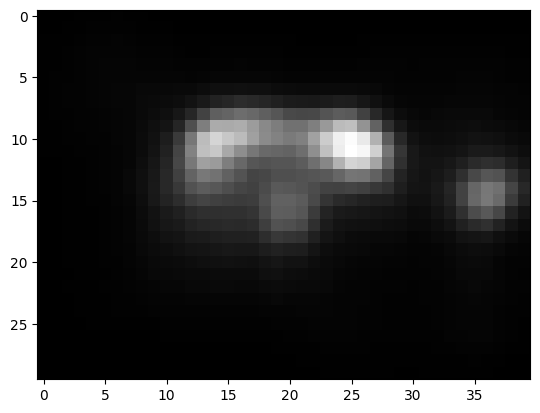

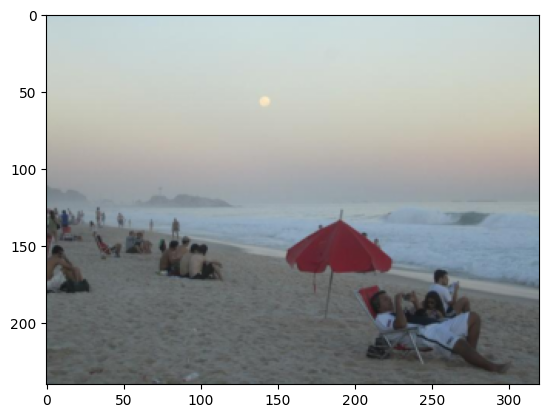

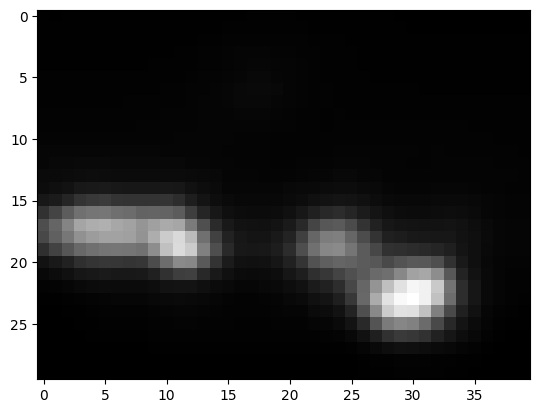

In [17]:
with torch.no_grad():
    model.eval()
    model.cuda()
    i = 0
    for images in loader_test:
        if i >= 10: 
            break
        i = i+1
        preds = model(images.cuda()).cpu()
        heatmap_h = preds.size(2)
        heatmap_w = preds.size(3)

        plt.imshow(images[0].permute(1, 2, 0))
        plt.show()

        temperature = 0.4
        tempered_pred = torch.log(torch.softmax(preds[0].view(-1), dim=0)) / temperature
        tempered_pred = torch.exp(tempered_pred) / torch.sum(torch.exp(tempered_pred))

        pred = tempered_pred.view(heatmap_h, heatmap_w)
        plt.imshow(pred, cmap='Greys_r')
        plt.show()